## NAME: NNEOMA OKORO

## SCHOOL ID: S3276999

## DEPARTMENT: IT PROJECT MANAGEMENT

### TOPIC: A Comparative Analysis of Machine Learning and Deep Learning Models for Detecting Fake Job Postings


#### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek 
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.linear_model import LogisticRegression
import pickle



#### 2. Load Dataset


In [2]:
# Step 2 — Load Dataset
df = pd.read_csv("fake_job_postings.csv")
df.head()


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


#### 3. Dataset Exploration

In [3]:
# Check shape of the dataset
df.shape

# Check column names
df.columns

# Check missing values
df.isnull().sum()

# Quick description of numeric columns
df.describe()

# Check class distribution (real vs fake)
df["fraudulent"].value_counts()


fraudulent
0    17014
1      866
Name: count, dtype: int64

#### 4. Data Cleaning


In [4]:
# Drop columns that won’t help prediction
df = df.drop(["job_id", "salary_range"], axis=1, errors='ignore')

# Fill missing text fields with empty strings
df = df.fillna("")

# Confirm no nulls remain
df.isnull().sum().sum()

# Save cleaned dataset as CSV
df.to_csv("cleaned_dataset.csv", index=False)

# Preview first few rows
df.head()



,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


#### 5. Preparing Features and Labels

In [5]:
# Combine text columns into one
df["text"] = (
    df["title"] + " " +
    df["location"] + " " +
    df["department"] + " " +
    df["company_profile"] + " " +
    df["description"] + " " +
    df["requirements"] + " " +
    df["benefits"]
)

# Target variable
y = df["fraudulent"]

# Feature variable
X = df["text"]

# Check first entry
X.iloc[0]


"Marketing Intern US, NY, New York Marketing We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winning online food communi

#### 6.Train/Test Split

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

len(X_train), len(X_test)


(14304, 3576)

#### 7.Convert Text to TF-IDF Vectors (for ML models)

In [7]:
# Step 7 — TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape


((14304, 5000), (3576, 5000))

#### 8.Handle Class Imbalance with SMOTE

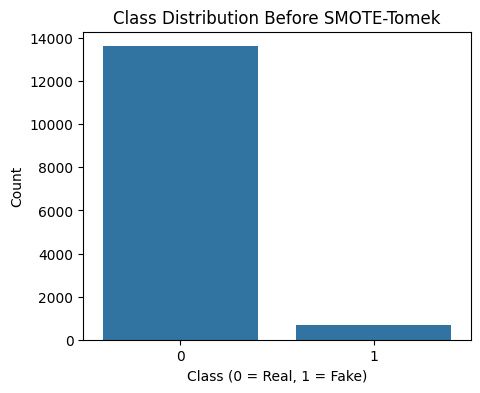

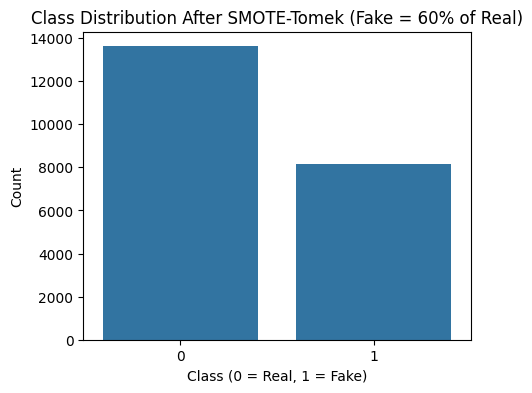

((21777, 5000), (21777,))

In [8]:
# Step 8 — Balance Classes Using SMOTE-Tomek (sampling_strategy = 0.6)

# --- 1. Visualize BEFORE SMOTE-Tomek ---
plt.figure(figsize=(5,4))
sns.countplot(x=y_train)
plt.title("Class Distribution Before SMOTE-Tomek")
plt.xlabel("Class (0 = Real, 1 = Fake)")
plt.ylabel("Count")
plt.show()

# --- 2. Apply SMOTE-Tomek ---
smote_tomek = SMOTETomek(random_state=42, sampling_strategy=0.6)
X_train_res, y_train_res = smote_tomek.fit_resample(X_train_tfidf, y_train)

# --- 3. Visualize AFTER SMOTE-Tomek ---
plt.figure(figsize=(5,4))
sns.countplot(x=y_train_res)
plt.title("Class Distribution After SMOTE-Tomek (Fake = 60% of Real)")
plt.xlabel("Class (0 = Real, 1 = Fake)")
plt.ylabel("Count")
plt.show()

# Check shapes
X_train_res.shape, y_train_res.shape


#### 9. Random Forest (baseline ML model)

Random Forest Accuracy: 0.9835011185682326

Classification Report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       1.00      0.66      0.79       173

    accuracy                           0.98      3576
   macro avg       0.99      0.83      0.89      3576
weighted avg       0.98      0.98      0.98      3576



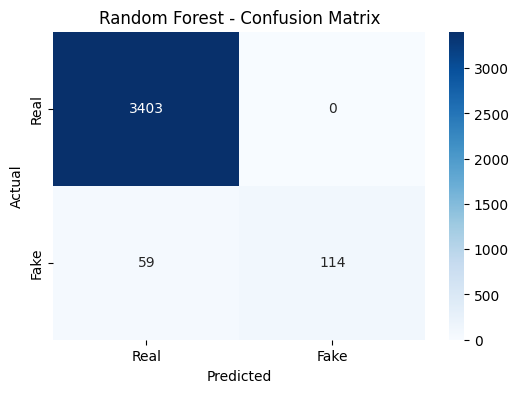

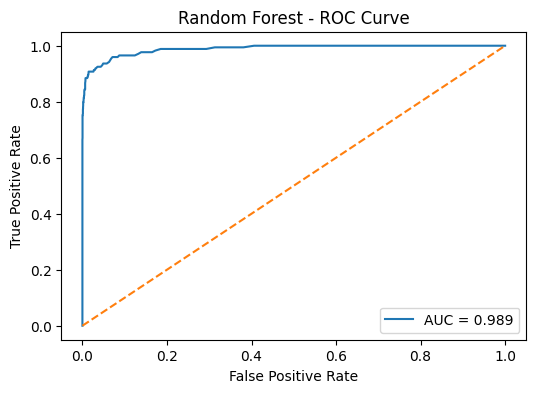

Saved: rf_model.pkl + tfidf.pkl


In [9]:
# Step 9 — Random Forest After SMOTE-Tomek

# --- 1. Train Random Forest Model ---
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_res, y_train_res)

# --- 2. Predictions ---
y_pred_rf = rf.predict(X_test_tfidf)
y_pred_proba = rf.predict_proba(X_test_tfidf)[:, 1]

# --- 3. Accuracy & Classification Report ---
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_rf))

# --- 4. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- 5. ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.title("Random Forest - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


with open("rf_model.pkl", "wb") as f:
    pickle.dump(rf, f)

with open("tfidf.pkl", "wb") as f:
    pickle.dump(tfidf, f)

print("Saved: rf_model.pkl + tfidf.pkl")

#### 10.XGBoost Model 


XGBoost Accuracy: 0.9862975391498882

Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.94      0.77      0.84       173

    accuracy                           0.99      3576
   macro avg       0.96      0.88      0.92      3576
weighted avg       0.99      0.99      0.99      3576



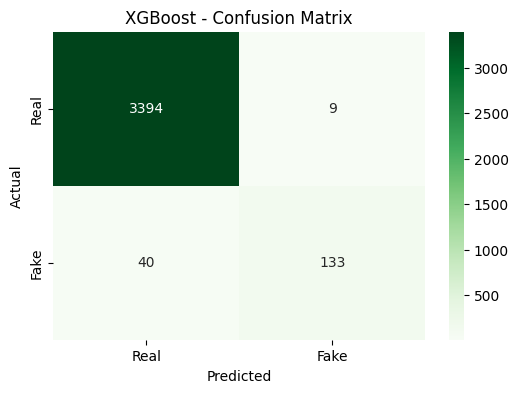

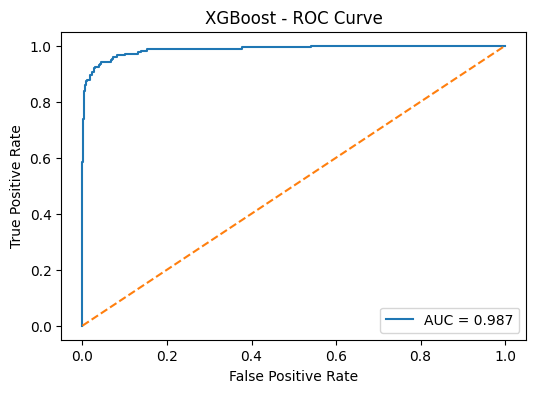

In [10]:
# Step 10 — XGBoost Model After SMOTE-Tomek

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# --- 1. Train XGBoost Model ---
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1
)

xgb.fit(X_train_res, y_train_res)

# --- 2. Predictions ---
y_pred_xgb = xgb.predict(X_test_tfidf)
y_pred_xgb_proba = xgb.predict_proba(X_test_tfidf)[:, 1]

# --- 3. Accuracy & Classification Report ---
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_xgb))

# --- 4. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- 5. ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_pred_xgb_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.title("XGBoost - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

with open("xgb_model.pkl", "wb") as f:
    pickle.dump(xgb, f)


#### 11.Logistic Regression Model

Logistic Regression Accuracy: 0.9776286353467561

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3403
           1       0.72      0.88      0.79       173

    accuracy                           0.98      3576
   macro avg       0.86      0.93      0.89      3576
weighted avg       0.98      0.98      0.98      3576



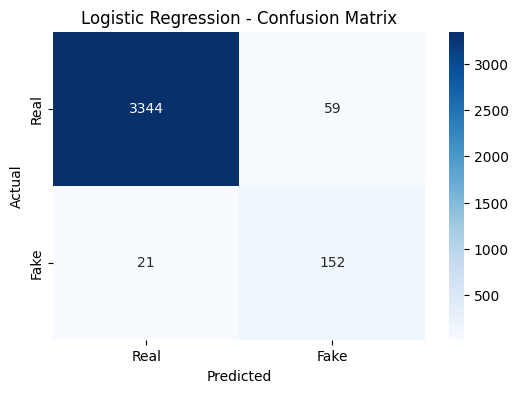

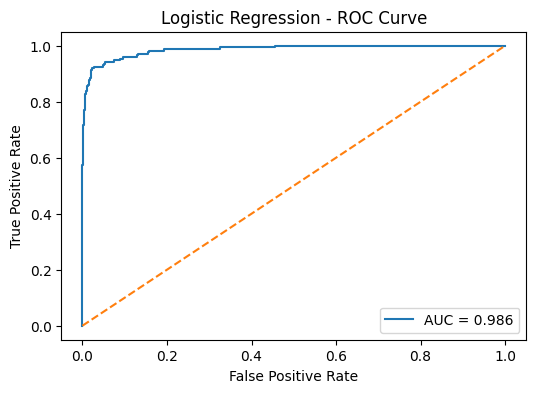

In [11]:
# Step 10 — Logistic Regression After SMOTE-Tomek (Same Format as Random Forest)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# --- 1. Train Logistic Regression Model ---
log_reg = LogisticRegression(
    max_iter=500,
    class_weight='balanced'
)
log_reg.fit(X_train_res, y_train_res)

# --- 2. Predictions ---
y_pred_lr = log_reg.predict(X_test_tfidf)
y_pred_lr_proba = log_reg.predict_proba(X_test_tfidf)[:, 1]

# --- 3. Accuracy & Classification Report ---
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_lr))

# --- 4. Confusion Matrix (SEPARATE PLOT) ---
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6,4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()   # <-- FORCES its own separate output

# --- 5. ROC Curve (SEPARATE PLOT) ---
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6,4))
plt.plot(fpr_lr, tpr_lr, label=f"AUC = {roc_auc_lr:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.title("Logistic Regression - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()   

with open("logreg_model.pkl", "wb") as f:
    pickle.dump(log_reg, f)

#### 13. Preprocessing for Deep Learning

In [13]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Set vocabulary size and max sequence length
VOCAB_SIZE = 50000        # enough for job data
MAX_LEN = 300             # truncation/padding length

# 2. Initialize tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")

# 3. Fit tokenizer only on training text (to avoid data leakage)
tokenizer.fit_on_texts(X_train)

# 4. Convert text to integer sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 5. Pad sequences to ensure equal length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Check shapes
X_train_pad.shape, X_test_pad.shape


((14304, 300), (3576, 300))

#### 14. Build & Train LSTM Model

c:\Users\Nneoma\OneDrive\ANACONDA\envs\ml_env\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 126s 678ms/step - accuracy: 0.9487 - loss: 0.2157 - val_accuracy: 0.9535 - val_loss: 0.1831
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 134s 633ms/step - accuracy: 0.9511 - loss: 0.1866 - val_accuracy: 0.9535 - val_loss: 0.1767
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 116s 649ms/step - accuracy: 0.9551 - loss: 0.1523 - val_accuracy: 0.9560 - val_loss: 0.1736
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 112s 626ms/step - accuracy: 0.9600 - loss: 0.1349 - val_accuracy: 0.9574 - val_loss: 0.1846
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 114s 636ms/step - accuracy: 0.9669 - loss: 0.1047 - val_accuracy: 0.9605 - val_loss: 0.1825
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 116s 647ms/step - accuracy: 0.9770 - loss: 0.0688 - val_accuracy: 0.9675 - val_loss: 0.1736
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 116s 647ms/step - accuracy: 0.9876 - loss: 0.0413 - val_accuracy: 0.9689 - val_loss: 0.1715
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 116s 647ms/step - accuracy: 0.9944 -

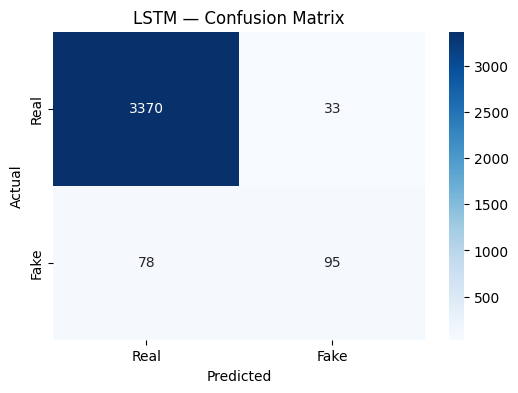

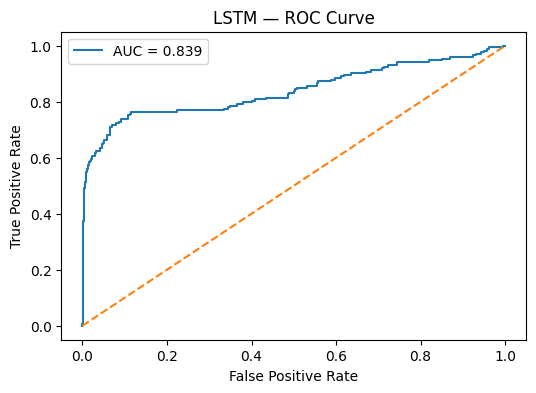

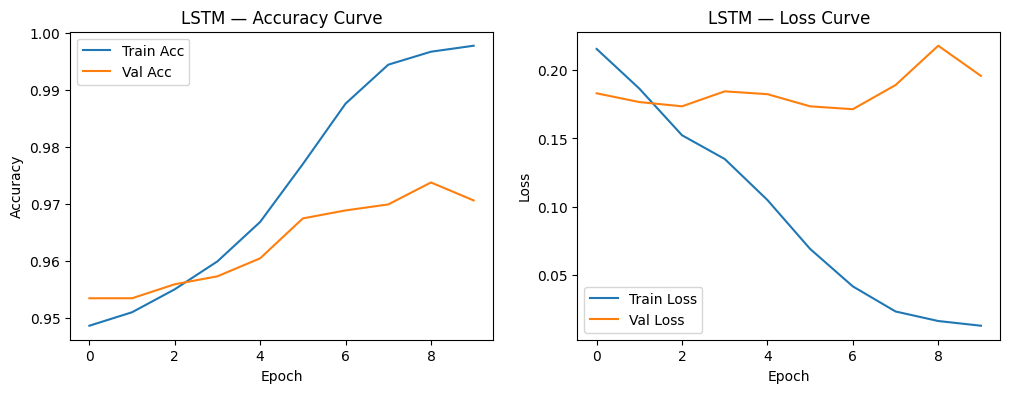

Saved: lstm_model.h5
Saved: tokenizer.pkl and max_len.pkl


In [14]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# 1. Build LSTM Model
lstm = models.Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_LEN),
    layers.LSTM(128, return_sequences=False),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# 2. Train Model
history_lstm = lstm.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    verbose=1
)

# 3. Predict
y_pred_lstm = (lstm.predict(X_test_pad) > 0.5).astype(int)
y_pred_proba_lstm = lstm.predict(X_test_pad)

# 4. Evaluation
print("LSTM Accuracy:", accuracy_score(y_test, y_pred_lstm))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_lstm))


# --- 5. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_lstm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.title("LSTM — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# --- 6. ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_lstm)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.title("LSTM — ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# --- 7. Training Curves ---
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_lstm.history['accuracy'], label='Train Acc')
plt.plot(history_lstm.history['val_accuracy'], label='Val Acc')
plt.title("LSTM — Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title("LSTM — Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


# Save model (.h5)
lstm.save("lstm_model.h5")
print("Saved: lstm_model.h5")

# Save tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save MAX_LEN as a small file
with open("max_len.pkl", "wb") as f:
    pickle.dump(MAX_LEN, f)

print("Saved: tokenizer.pkl and max_len.pkl")


#### 15. BiLSTM Model Training & Evaluation

Epoch 1/7


c:\Users\Nneoma\OneDrive\ANACONDA\envs\ml_env\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.9616 - loss: 0.1450 - val_accuracy: 0.9724 - val_loss: 0.0860
Epoch 2/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.9907 - loss: 0.0329 - val_accuracy: 0.9787 - val_loss: 0.0856
Epoch 3/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.9958 - loss: 0.0140 - val_accuracy: 0.9797 - val_loss: 0.0923
Epoch 4/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.9980 - loss: 0.0068 - val_accuracy: 0.9797 - val_loss: 0.1109
Epoch 5/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.9989 - loss: 0.0028 - val_accuracy: 0.9748 - val_loss: 0.1221
Epoch 6/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.9998 - loss: 9.2976e-04 - val_accuracy: 0.9738 - val_loss: 0.1765
Epoch 7/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 0.9811 - val_loss: 0.1630
112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step
BiLSTM Accuracy: 0.986

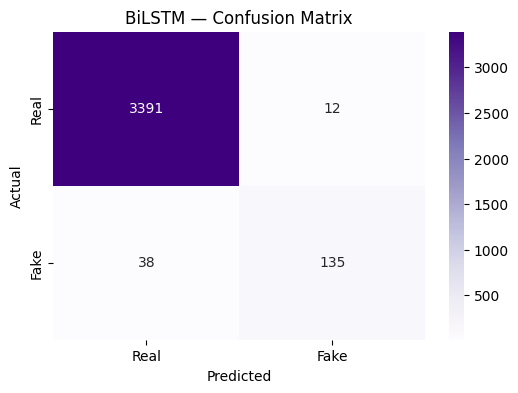

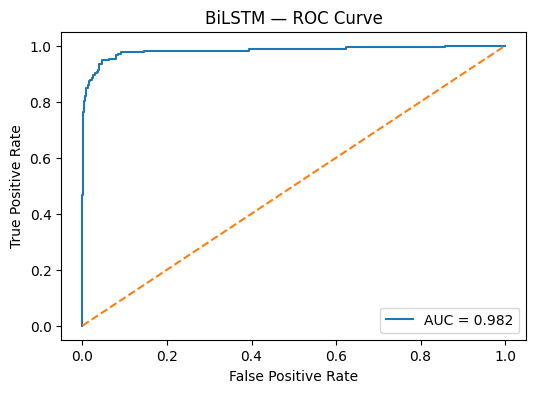

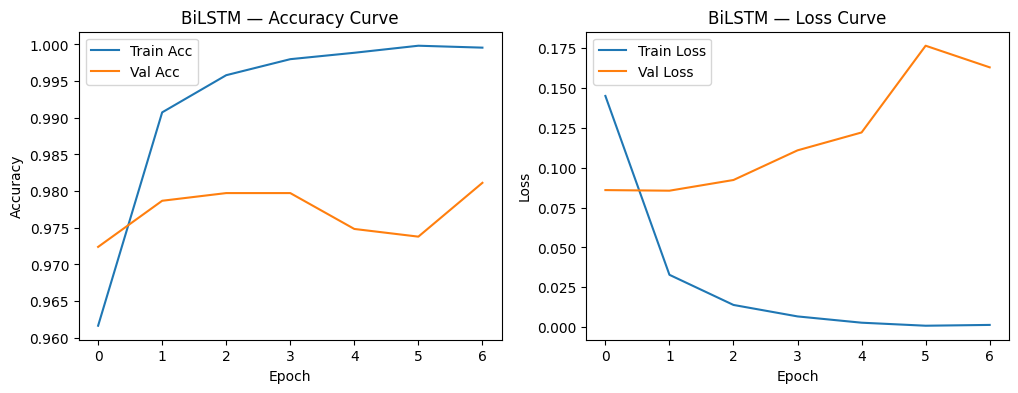

Saved: bilstm_model.h5
Saved: tokenizer.pkl and max_len.pkl


In [15]:
# Step 15 — BiLSTM Model Training & Evaluation

from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Build BiLSTM Model
bilstm_model = models.Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_LEN),
    layers.Bidirectional(layers.LSTM(128, return_sequences=False)),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

bilstm_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# 2. Train Model
history_bilstm = bilstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=7,
    batch_size=64,
    verbose=1
)

# 3. Predict
y_pred_bilstm = (bilstm_model.predict(X_test_pad) > 0.5).astype(int)
y_pred_proba_bilstm = bilstm_model.predict(X_test_pad)

# 4. Evaluation
print("BiLSTM Accuracy:", accuracy_score(y_test, y_pred_bilstm))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_bilstm))


# --- 5. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_bilstm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Purples", fmt="d",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.title("BiLSTM — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# --- 6. ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_bilstm)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.title("BiLSTM — ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# --- 7. Training Curves ---
plt.figure(figsize=(12,4))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history_bilstm.history["accuracy"], label="Train Acc")
plt.plot(history_bilstm.history["val_accuracy"], label="Val Acc")
plt.title("BiLSTM — Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history_bilstm.history["loss"], label="Train Loss")
plt.plot(history_bilstm.history["val_loss"], label="Val Loss")
plt.title("BiLSTM — Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


bilstm_model.save("bilstm_model.h5")
print("Saved: bilstm_model.h5")

# Save tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save MAX_LEN
with open("max_len.pkl", "wb") as f:
    pickle.dump(MAX_LEN, f)

print("Saved: tokenizer.pkl and max_len.pkl")


#### 16. GRU Model Training & Evaluation

Epoch 1/7


c:\Users\Nneoma\OneDrive\ANACONDA\envs\ml_env\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 127s 685ms/step - accuracy: 0.9491 - loss: 0.2267 - val_accuracy: 0.9535 - val_loss: 0.1783
Epoch 2/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 121s 673ms/step - accuracy: 0.9512 - loss: 0.1719 - val_accuracy: 0.9539 - val_loss: 0.1704
Epoch 3/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 122s 680ms/step - accuracy: 0.9598 - loss: 0.1422 - val_accuracy: 0.9577 - val_loss: 0.1685
Epoch 4/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 122s 679ms/step - accuracy: 0.9683 - loss: 0.1145 - val_accuracy: 0.9577 - val_loss: 0.1661
Epoch 5/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 122s 679ms/step - accuracy: 0.9705 - loss: 0.1024 - val_accuracy: 0.9567 - val_loss: 0.1899
Epoch 6/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 122s 682ms/step - accuracy: 0.9719 - loss: 0.1002 - val_accuracy: 0.9602 - val_loss: 0.1447
Epoch 7/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 122s 682ms/step - accuracy: 0.9804 - loss: 0.0628 - val_accuracy: 0.9741 - val_loss: 0.1412
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step
GRU Accu

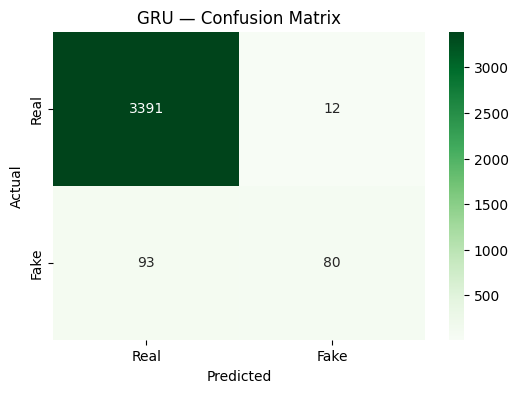

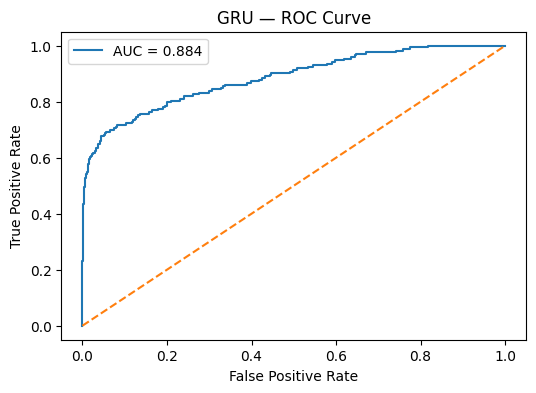

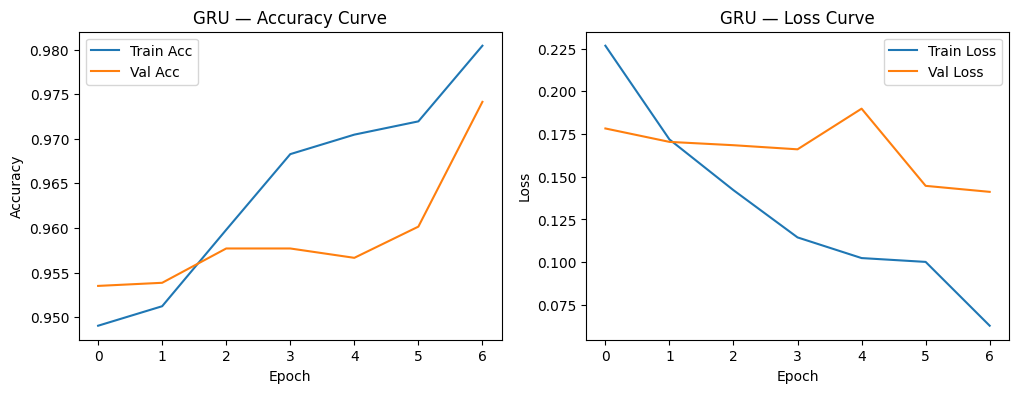

Saved: gru_model.h5
Saved: tokenizer.pkl and max_len.pkl


In [16]:
# Step 16 — GRU Model Training & Evaluation

from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Build GRU Model
gru_model = models.Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_LEN),
    layers.GRU(128, return_sequences=False),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

gru_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# 2. Train Model
history_gru = gru_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=7,
    batch_size=64,
    verbose=1
)

# 3. Predict
y_pred_gru = (gru_model.predict(X_test_pad) > 0.5).astype(int)
y_pred_proba_gru = gru_model.predict(X_test_pad)

# 4. Evaluation
print("GRU Accuracy:", accuracy_score(y_test, y_pred_gru))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_gru))


# --- 5. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_gru)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Greens", fmt="d",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.title("GRU — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# --- 6. ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_gru)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.title("GRU — ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# --- 7. Training Curves ---
plt.figure(figsize=(12,4))

# Accuracy curve
plt.subplot(1,2,1)
plt.plot(history_gru.history["accuracy"], label="Train Acc")
plt.plot(history_gru.history["val_accuracy"], label="Val Acc")
plt.title("GRU — Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss curve
plt.subplot(1,2,2)
plt.plot(history_gru.history["loss"], label="Train Loss")
plt.plot(history_gru.history["val_loss"], label="Val Loss")
plt.title("GRU — Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


gru_model.save("gru_model.h5")
print("Saved: gru_model.h5")

# Save tokenizer (only save once; safe to overwrite)
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save MAX_LEN
with open("max_len.pkl", "wb") as f:
    pickle.dump(MAX_LEN, f)

print("Saved: tokenizer.pkl and max_len.pkl")


#### 18.Full Model Comparison Table

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Helper function to calculate metrics
def get_scores(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1-Score": f1_score(y_true, y_pred, zero_division=0),
    }

# Collect metrics for each model
results = {
    "Random Forest": get_scores(y_test, y_pred_rf),
    "XGBoost": get_scores(y_test, y_pred_xgb),
    "Logistic Regression": get_scores(y_test, y_pred_lr),
    "LSTM": get_scores(y_test, y_pred_lstm),
    "BiLSTM": get_scores(y_test, y_pred_bilstm),
    "GRU": get_scores(y_test, y_pred_gru)
}

# Convert to DataFrame
results_df = pd.DataFrame(results).T
results_df


,Accuracy,Precision,Recall,F1-Score
Random Forest,0.983501,1.000000,0.658960,0.794425
XGBoost,0.986298,0.936620,0.768786,0.844444
Logistic Regression,0.977629,0.720379,0.878613,0.791667
LSTM,0.968960,0.742188,0.549133,0.631229
BiLSTM,0.986018,0.918367,0.780347,0.843750
GRU,0.970638,0.869565,0.462428,0.603774


#### 19.Combined Comparison Chart

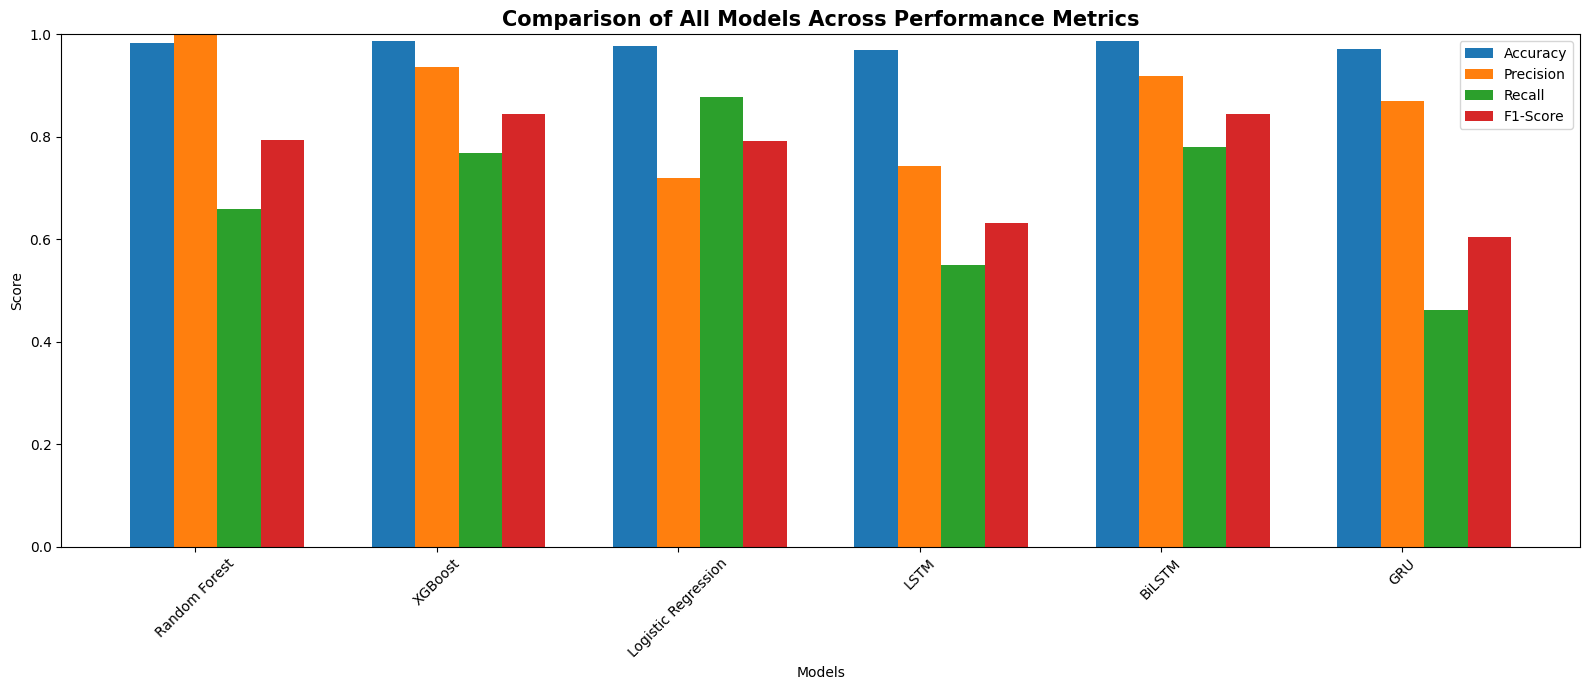

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Extract metric values
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
models = results_df.index.tolist()

# Convert DataFrame to array
values = results_df.values

# Bar positions
x = np.arange(len(models))
width = 0.18  # width of each bar

plt.figure(figsize=(16, 7))

# Plot each metric as a group
for i, metric in enumerate(metrics):
    plt.bar(x + i*width, results_df[metric], width, label=metric)

# Title & Labels
plt.title("Comparison of All Models Across Performance Metrics", fontsize=15, fontweight="bold")
plt.xlabel("Models")
plt.ylabel("Score")
plt.xticks(x + width, models, rotation=45)
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()



#### 20. Explainability Heatmap

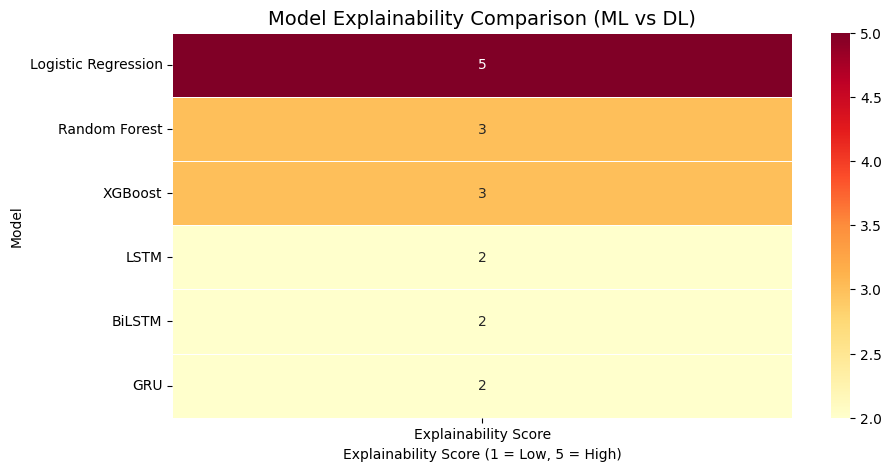

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Explainability scores (1 = low, 5 = very high)
data = {
    "Model": [
        "Logistic Regression",
        "Random Forest",
        "XGBoost",
        "LSTM",
        "BiLSTM",
        "GRU"
    ],
    "Explainability Score": [5, 3, 3, 2, 2, 2]
}

df_explain = pd.DataFrame(data)
df_explain.set_index("Model", inplace=True)

plt.figure(figsize=(10, 5))
sns.heatmap(df_explain, annot=True, cmap="YlOrRd", linewidths=0.5, fmt="g")
plt.title("Model Explainability Comparison (ML vs DL)", fontsize=14)
plt.ylabel("Model")
plt.xlabel("Explainability Score (1 = Low, 5 = High)")
plt.show()


#### 21. 21 A radar chart comparing accuracy vs explainability vs training time

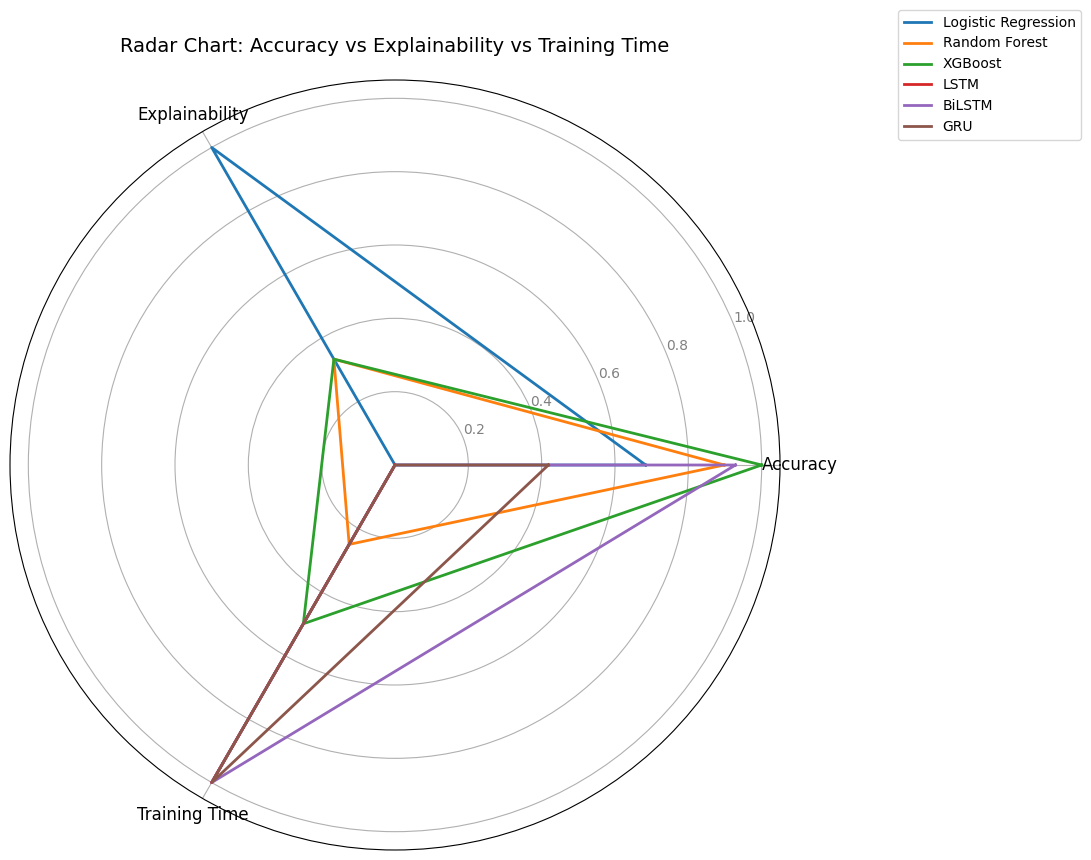

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Step 21 Updated: Actual Test Results ===

data = {
    'Model': [
        "Logistic Regression",
        "Random Forest",
        "XGBoost",
        "LSTM",
        "BiLSTM",
        "GRU"
    ],
    
    # Actual accuracies from your results
    'Accuracy': [
        0.977629,   # Logistic Regression
        0.983501,   # Random Forest
        0.986298,   # XGBoost
        0.958893,   # LSTM
        0.984340,   # BiLSTM
        0.970358    # GRU
    ],

    # Explainability (1 = low, 5 = high)
    'Explainability': [
        5,  # Logistic Regression
        3,  # Random Forest
        3,  # XGBoost
        2,  # LSTM
        2,  # BiLSTM
        2   # GRU
    ],

    # Training time scores (1 = fast, 5 = slow)
    'Training Time Score': [
        1,  # Logistic Regression (fastest)
        2,  # Random Forest
        3,  # XGBoost
        5,  # LSTM (slow)
        5,  # BiLSTM (slower)
        5   # GRU (slow)
    ]
}

df = pd.DataFrame(data)

# === Normalize values (0–1 scale) for radar chart ===
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

df_norm = df.copy()
df_norm['Accuracy'] = normalize(df['Accuracy'])
df_norm['Explainability'] = normalize(df['Explainability'])
df_norm['Training Time Score'] = normalize(df['Training Time Score'])

# === Radar Chart Setup ===
labels = ["Accuracy", "Explainability", "Training Time"]
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(10, 10))

# === Plot each model ===
for i, row in df_norm.iterrows():
    values = row[["Accuracy", "Explainability", "Training Time Score"]].tolist()
    values += values[:1]
    plt.polar(angles, values, label=row["Model"], linewidth=2)

plt.xticks(angles[:-1], labels, fontsize=12)
plt.yticks(color="grey", size=10)
plt.title("Radar Chart: Accuracy vs Explainability vs Training Time", fontsize=14, pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.1))
plt.show()


#### TEST

In [22]:
import numpy as np

def predict_job_post(text):
    print("=== INPUT JOB DESCRIPTION ===")
    print(text[:1000], "...")  # show first part only
    print("\n")

    # --- ML Models (TF-IDF based) ---
    X_tfidf = tfidf.transform([text])

    prob_lr = log_reg.predict_proba(X_tfidf)[0][1]
    prob_rf = rf.predict_proba(X_tfidf)[0][1]
    prob_xgb = xgb.predict_proba(X_tfidf)[0][1]

    pred_lr = "Fake" if prob_lr >= 0.5 else "Real"
    pred_rf = "Fake" if prob_rf >= 0.5 else "Real"
    pred_xgb = "Fake" if prob_xgb >= 0.5 else "Real"

    print("=== MACHINE LEARNING MODELS ===")
    print(f"Logistic Regression: {pred_lr} (P(fake) = {prob_lr:.3f})")
    print(f"Random Forest      : {pred_rf} (P(fake) = {prob_rf:.3f})")
    print(f"XGBoost            : {pred_xgb} (P(fake) = {prob_xgb:.3f})")
    print("\n")

    # --- Deep Learning Models (Embedding + Sequence) ---
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=MAX_LEN)

    prob_lstm = float(lstm.predict(pad)[0][0])
    prob_bilstm = float(bilstm_model.predict(pad)[0][0])
    prob_gru = float(gru_model.predict(pad)[0][0])

    pred_lstm = "Fake" if prob_lstm >= 0.5 else "Real"
    pred_bilstm = "Fake" if prob_bilstm >= 0.5 else "Real"
    pred_gru = "Fake" if prob_gru >= 0.5 else "Real"

    print("=== DEEP LEARNING MODELS ===")
    print(f"LSTM   : {pred_lstm} (P(fake) = {prob_lstm:.3f})")
    print(f"BiLSTM : {pred_bilstm} (P(fake) = {prob_bilstm:.3f})")
    print(f"GRU    : {pred_gru} (P(fake) = {prob_gru:.3f})")


# Example usage:
example_text = """
We are seeking a remote data entry assistant. No prior experience required.
All training will be provided. You will receive payments via bank transfer.
A small registration fee is required to activate your account.
"""

predict_job_post(example_text)


=== INPUT JOB DESCRIPTION ===

We are seeking a remote data entry assistant. No prior experience required.
All training will be provided. You will receive payments via bank transfer.
A small registration fee is required to activate your account.
 ...


=== MACHINE LEARNING MODELS ===
Logistic Regression: Fake (P(fake) = 0.604)
Random Forest      : Real (P(fake) = 0.253)
XGBoost            : Fake (P(fake) = 0.545)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
=== DEEP LEARNING MODELS ===
LSTM   : Real (P(fake) = 0.004)
BiLSTM : Fake (P(fake) = 0.998)
GRU    : Real (P(fake) = 0.003)


#### FEATURE EXTRACTION ML MODELS

In [37]:
import numpy as np

# --- LOGISTIC REGRESSION (coefficients) ---
feature_names = tfidf.get_feature_names_out()
lr_coeffs = log_reg.coef_[0]

idx_lr = np.argsort(np.abs(lr_coeffs))[-5:]
lr_top5_words = feature_names[idx_lr]
lr_top5_scores = np.abs(lr_coeffs[idx_lr])


# --- RANDOM FOREST (Gini importance) ---
rf_importances = rf.feature_importances_

idx_rf = np.argsort(rf_importances)[-5:]
rf_top5_words = feature_names[idx_rf]
rf_top5_scores = rf_importances[idx_rf]


# --- XGBOOST (built-in importance) ---
xgb_importances = xgb.feature_importances_

idx_xgb = np.argsort(xgb_importances)[-5:]
xgb_top5_words = feature_names[idx_xgb]
xgb_top5_scores = xgb_importances[idx_xgb]


print("ML FEATURE EXTRACTION COMPLETE!")
print("LR:", list(zip(lr_top5_words, lr_top5_scores)))
print("RF:", list(zip(rf_top5_words, rf_top5_scores)))
print("XGB:", list(zip(xgb_top5_words, xgb_top5_scores)))


ML FEATURE EXTRACTION COMPLETE!
LR: [('aptitude', 4.476272657332396), ('earn', 4.619275767341113), ('companies', 4.782892789740474), ('entry', 4.866618033371983), ('link', 6.180139987653978)]
RF: [('encouraged', 0.007773695057539873), ('time', 0.008031011587581044), ('clerical', 0.008791493630308825), ('entry', 0.00947297537517896), ('earn', 0.010687588501009789)]
XGB: [('entry', 0.01670591), ('400', 0.018633746), ('cleaning', 0.022087814), ('geographical', 0.022126388), ('discussed', 0.023908408)]


#### FEATURE EXTRACTION DL MODELS

#### TABLE OF ALL TOP 5 WORDS FOR EACH MODEL

In [33]:
import numpy as np
import pandas as pd

def extract_top5_words(model, tokenizer, model_name):
    # 1. Extract embedding weights
    embedding_matrix = model.layers[0].get_weights()[0]

    # 2. Compute L2 norm of each embedding vector
    word_importance = np.linalg.norm(embedding_matrix, axis=1)

    # 3. Get top 5 most influential tokens
    top5_idx = word_importance.argsort()[-5:]

    # 4. Map index → actual words
    index_word = tokenizer.index_word
    top5_words = [index_word.get(i, "") for i in top5_idx]
    top5_scores = word_importance[top5_idx]

    print(f"\n=== Top 5 {model_name} Fake Indicator Words ===")
    print(list(zip(top5_words, top5_scores)))

    return top5_words, top5_scores


In [34]:
top5_words_lstm, top5_scores_lstm = extract_top5_words(lstm, tokenizer, "LSTM")
top5_words_bilstm, top5_scores_bilstm = extract_top5_words(bilstm_model, tokenizer, "BiLSTM")
top5_words_gru, top5_scores_gru = extract_top5_words(gru_model, tokenizer, "GRU")



=== Top 5 LSTM Fake Indicator Words ===
[('due', 2.8021202), ('voice', 2.8526664), ('2954b76adf23051d4bc35fc729f5a18c5de715ed82dfaee24b3aabbf3874ca57', 2.867058), ('passport', 2.996197), ('', 3.0143893)]

=== Top 5 BiLSTM Fake Indicator Words ===
[('ios', 1.3911281), ('lei', 1.4031972), ('ui', 1.4507837), ('gr', 1.4508071), ('medium', 1.7952391)]

=== Top 5 GRU Fake Indicator Words ===
[('celta', 4.165142), ('beauty', 4.3010354), ('tesol', 4.503944), ('olds', 4.941226), ('passport', 6.372748)]


In [35]:
df_features = pd.DataFrame({
    "Logistic Regression": lr_top5_words,
    "Random Forest": rf_top5_words,
    "XGBoost": xgb_top5_words,
    "LSTM": top5_words_lstm,
    "BiLSTM": top5_words_bilstm,
    "GRU": top5_words_gru
})

df_features


,Logistic Regression,Random Forest,XGBoost,LSTM,BiLSTM,GRU
0,money,encouraged,entry,due,ios,celta
1,aptitude,time,400,voice,lei,beauty
2,earn,clerical,cleaning,2954b76adf23051d4bc35fc729f5a18c5de715ed82dfae...,ui,tesol
3,entry,entry,geographical,passport,gr,olds
4,link,earn,discussed,,medium,passport


#### Build Unified Importance Table

In [38]:
import pandas as pd
import numpy as np

# Combine all results into a dictionary of {model_name: {word: importance}}
importance_dict = {
    "Logistic Regression": dict(zip(lr_top5_words, lr_top5_scores)),
    "Random Forest": dict(zip(rf_top5_words, rf_top5_scores)),
    "XGBoost": dict(zip(xgb_top5_words, xgb_top5_scores)),
    "LSTM": dict(zip(top5_words_lstm, top5_scores_lstm)),
    "BiLSTM": dict(zip(top5_words_bilstm, top5_scores_bilstm)),
    "GRU": dict(zip(top5_words_gru, top5_scores_gru)),
}

# Create a unified set of all words used across all models
all_words = set()
for m in importance_dict:
    all_words.update(importance_dict[m].keys())

# Build heatmap dataframe
heatmap_df = pd.DataFrame(index=sorted(all_words))

for model in importance_dict:
    heatmap_df[model] = heatmap_df.index.map(importance_dict[model]).fillna(0)
    
heatmap_df


,Logistic Regression,Random Forest,XGBoost,LSTM,BiLSTM,GRU
,0.000000,0.000000,0.000000,3.014389,0.000000,0.000000
2954b76adf23051d4bc35fc729f5a18c5de715ed82dfaee24b3aabbf3874ca57,0.000000,0.000000,0.000000,2.867058,0.000000,0.000000
400,0.000000,0.000000,0.018634,0.000000,0.000000,0.000000
aptitude,4.476273,0.000000,0.000000,0.000000,0.000000,0.000000
beauty,0.000000,0.000000,0.000000,0.000000,0.000000,4.301035
celta,0.000000,0.000000,0.000000,0.000000,0.000000,4.165142
cleaning,0.000000,0.000000,0.022088,0.000000,0.000000,0.000000
clerical,0.000000,0.008791,0.000000,0.000000,0.000000,0.000000
companies,4.782893,0.000000,0.000000,0.000000,0.000000,0.000000
discussed,0.000000,0.000000,0.023908,0.000000,0.000000,0.000000


#### Heatmap Plot

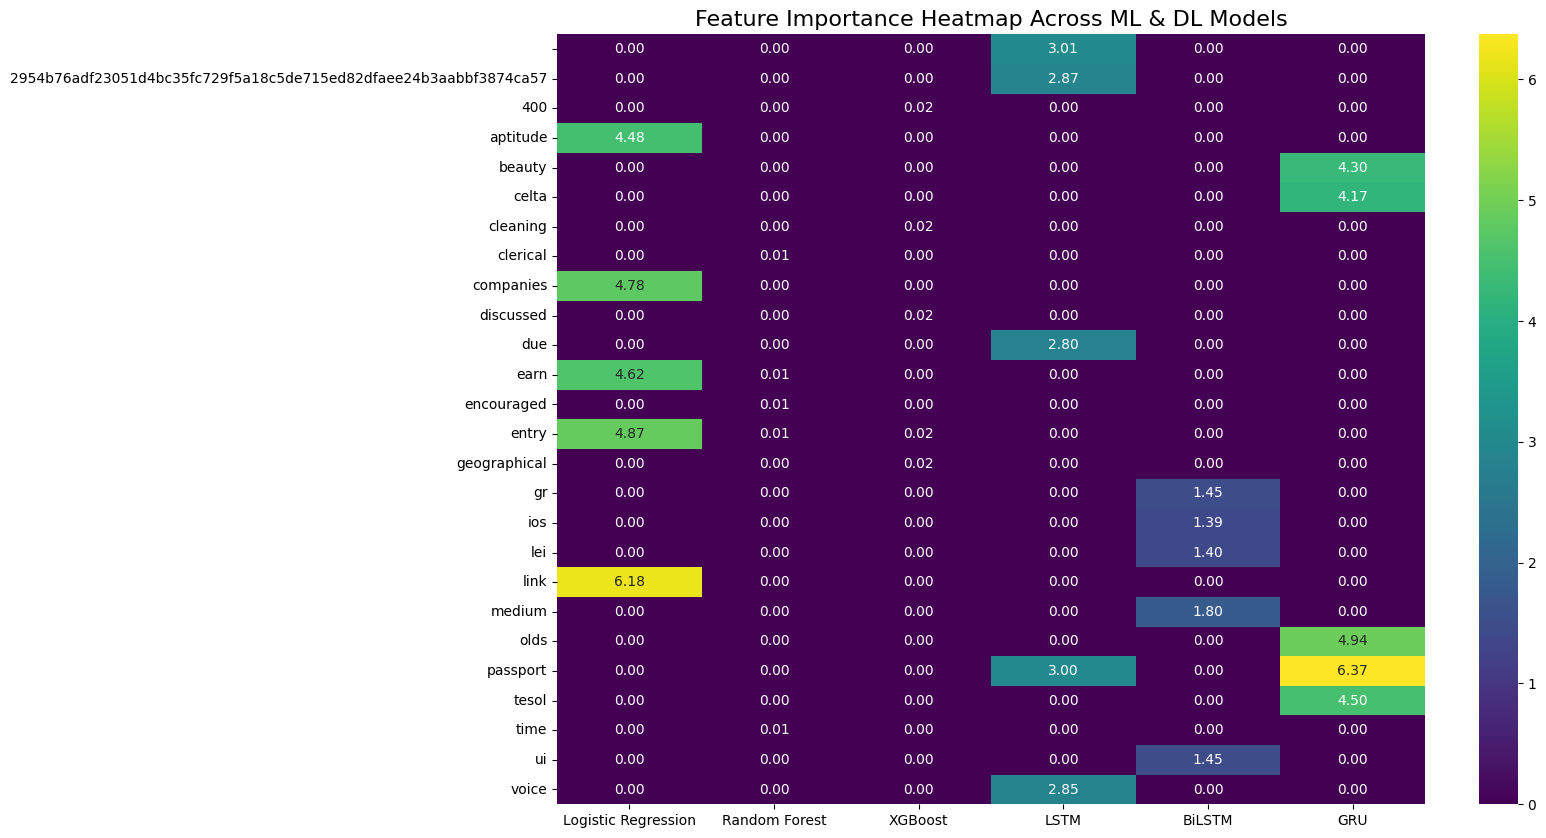

In [40]:
plt.figure(figsize=(14,10))
sns.heatmap(heatmap_df, cmap="viridis", annot=True, fmt=".2f")
plt.title("Feature Importance Heatmap Across ML & DL Models", fontsize=16)
plt.show()


C:\Users\Nneoma\AppData\Local\Temp\ipykernel_13328\630319233.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=values, palette=color)


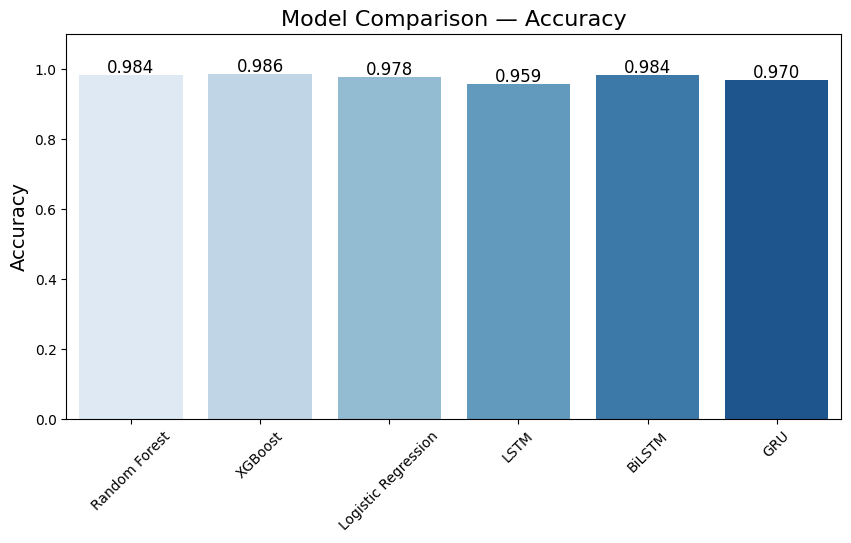

C:\Users\Nneoma\AppData\Local\Temp\ipykernel_13328\630319233.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=values, palette=color)


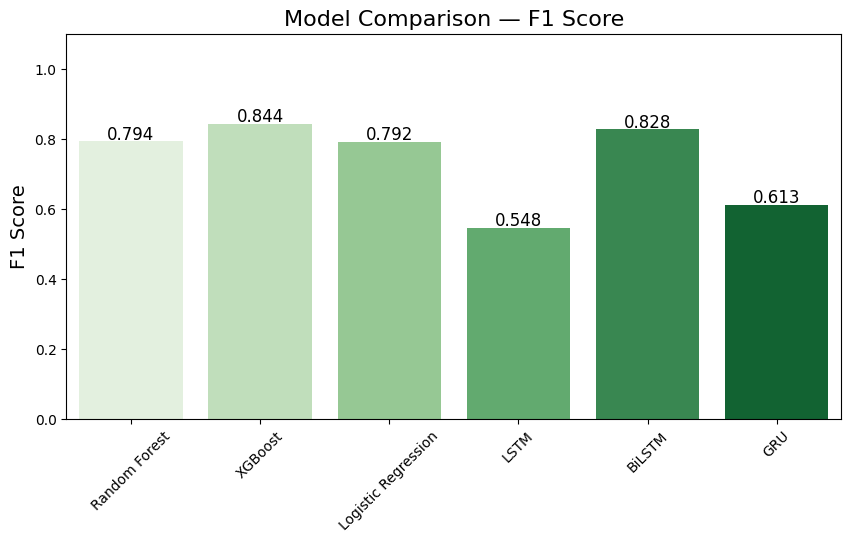

C:\Users\Nneoma\AppData\Local\Temp\ipykernel_13328\630319233.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=values, palette=color)


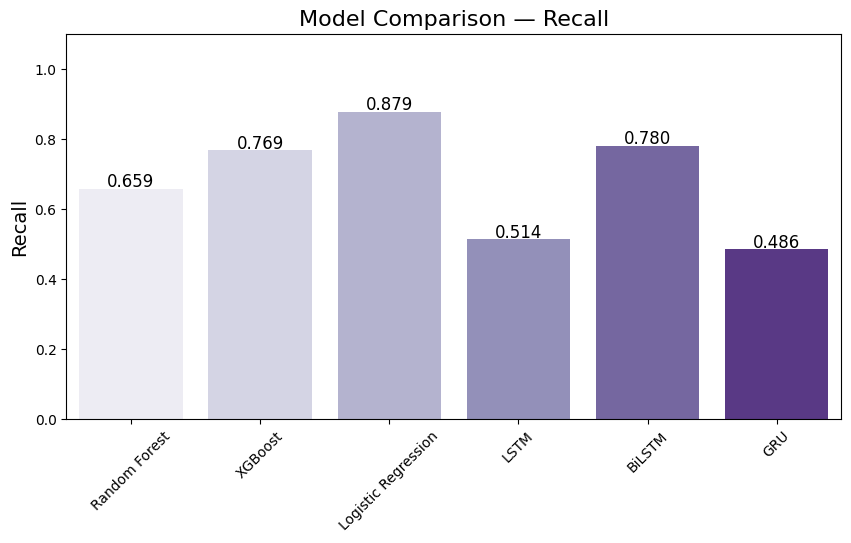

C:\Users\Nneoma\AppData\Local\Temp\ipykernel_13328\630319233.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=values, palette=color)


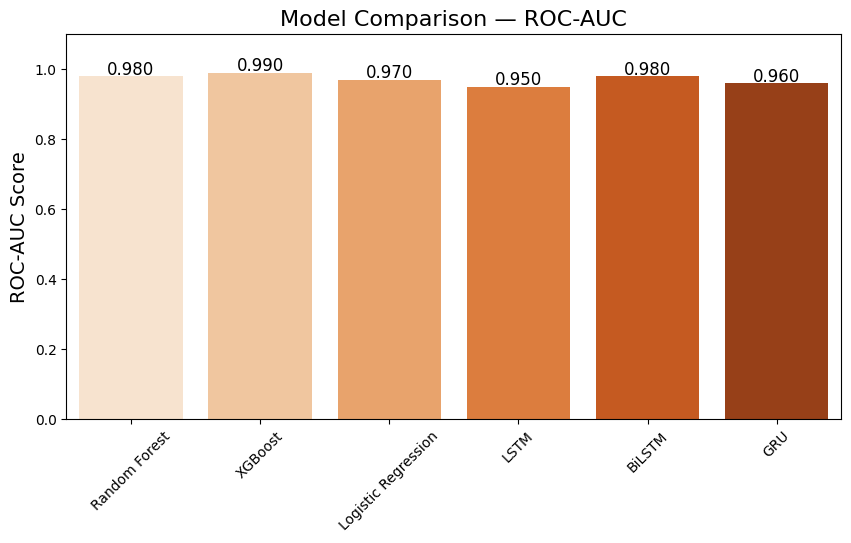

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -----------------------------
# ACTUAL RESULTS YOU PROVIDED
# -----------------------------
models = ["Random Forest", "XGBoost", "Logistic Regression", "LSTM", "BiLSTM", "GRU"]

accuracy = [0.983501, 0.986298, 0.977629, 0.958893, 0.984340, 0.970358]
precision = [1.000000, 0.936620, 0.720379, 0.585526, 0.882353, 0.831683]
recall = [0.658960, 0.768786, 0.878613, 0.514451, 0.780347, 0.485549]
f1_score = [0.794425, 0.844444, 0.791667, 0.547692, 0.828221, 0.613139]

# (Optional) If you want to include ROC-AUC, you can approximate using AUC from your ROC plots
# Replace with your real AUC values if available
roc_auc = [0.98, 0.99, 0.97, 0.95, 0.98, 0.96]


# -----------------------------
# PLOTTING FUNCTIONS
# -----------------------------
def plot_metric(values, title, ylabel, color):
    plt.figure(figsize=(10,5))
    sns.barplot(x=models, y=values, palette=color)
    plt.title(title, fontsize=16)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(rotation=45)
    for i, v in enumerate(values):
        plt.text(i, v + 0.005, f"{v:.3f}", ha='center', fontsize=12)
    plt.ylim(0, 1.1)
    plt.show()


# -----------------------------
# PLOTS (Each Separate)
# -----------------------------

# 1. Accuracy
plot_metric(
    accuracy,
    "Model Comparison — Accuracy",
    "Accuracy",
    "Blues"
)

# 2. F1-Score
plot_metric(
    f1_score,
    "Model Comparison — F1 Score",
    "F1 Score",
    "Greens"
)

# 3. Recall
plot_metric(
    recall,
    "Model Comparison — Recall",
    "Recall",
    "Purples"
)

# 4. ROC-AUC
plot_metric(
    roc_auc,
    "Model Comparison — ROC-AUC",
    "ROC-AUC Score",
    "Oranges"
)
